# Protein Folding Algorithm

Protein folding is the description of a three-dimensional structure of an amino acid chain, arranged in space to become a biologically functional protein.
Understanding the structure of protein is extremely valuable for various applications in medicine.
Discovering the structure of proteins is a highly intricate problem, as each protein is constructed of a chain of hundreds or thousands of amino acids, and the number of configurations is roughly evaluated to be $3^{2(N-1)}$ with N being the number of amino acids [1]. The exponential growth of conformations with the chain length N makes the problem very complex for classical computers. For a quantum computer, the algorithm grows linearly with the number of amino acids N that are conceived, as the one simulated below.

This tutorial presents a method of achieving a folding geometry for a given amino acid sequence. Following paper [2], we create a Pyomo optimization model, and send it to Classiq's Quantum Approximated Optimization Algorithm (QAOA), which finds the configuration with minimal energy. The results are later visualized and compared to a classical solution.

## Prerequisites

The model uses Classiq libraries in addition to basic Python tools:

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pyomo.core as pyo
from sympy import *

## Defining the Optimization Problem

Following the paper [2], create a Python Pyomo model to describe an optimization problem where a paramatrized cost expression characterizes the geometrical configuration of a protein (amino acid sequence).

Without going into too many details, the paper places the protein on the grid of a tetrahedral lattice. Each amino acid can be located in any vertex of the lattice, and an index is set to each amino acid. Since each vertex has four neighbors, after locating an index in space, the next location is set by pointing in one of the four directions indicated by an integer $[0,1,2,3]$. To ascribe a direction, assign each amino acid two qubits, thus mapping each index to a direction:

- $[00] \rightarrow 0$ 
- $[01] \rightarrow 1$ 
- $[10] \rightarrow 2$ 
- $[11] \rightarrow 3$ 

For the convenience of the coding, each even and odd index of amino acid has an opposite meaning in space; i.e., "0" means "left" for an odd index and "right" for an even index.

A protein of $N$ amino acids has $N-1$ directions (or edges). However, since the first two directions only set the orientation of the molecule in space but do not determine the relative location of the amino acids, there are $N-3$ directions. (In thethrader lattice, there is an equal angle between each three vertices, so the relations are the same for the first three, regardless of the chosen direction.) Thus, the required number of qubits to describe the directions in the lattice is $2(N-3)$, and the two first directions are set arbitrarily.

Next, set the Hamiltonian; i.e., the cost function that is sent to minimization. The Hamiltonian consists of two terms: $H_{gc}$ describing geometrical constraints, and $H_{int}$ describing the interactions between the amino acids (the paper also discusses a third chirality constraint that is only relevant to side chains, which are not considered in the scope of this algorithm):

* $H_{gc}$ - prevents two consecutive directions to fold back. Since this tutorial uses a convention where the odd and even indexes have an opposite meaning in space, it is sufficient to add a large penalty term if two consecutive directions are the same.

* $H_{int}$ - For the interaction, define extra qubits, which determine if the interaction is "turned on". If so, they add a negative (beneficial) energy term $epsilon$, which indicates the interaction between amino acids. $epsilon$ is a nearest neighbor (NN) interaction term, relevant for distance 1 only; therefore, add a penalty for other distances. Note that this tutorial takes the interaction to be a constant value ($epsilon$) regardless of the type of amino acid interaction. You can modify this by inserting the Miyazawa & Jernigan table [3].

Since it is trivial that the following amino acid in the sequence is the nearest neighbor, it is irrelevant to calculate the contributing energy from such an interaction (it adds a constant number regardless of the qubit’s value). In fact, due to the structure of the tetrahedral lattice, only amino acids further away than fifth in the sequence might have non-trivial interaction. Thus, the number of possible interactions (and thus the number of interaction qubits) is (N-5)*(N-4)/2 (calculated via arithmetic progression).

In addition, to prevent folding back into the chain, while encouraging distance 1 interactions, make sure that the indices following the two interacting amino acids do not overlap with the interacting amino acid themselves. In other words, for NN $(i,j)$, {i-1,i+1} must be at distance 2 (or else they will be at distance 0; i.e., overlapping). To account for that, add a penalty to the interaction term.

In [2]:
def folding_hamiltonian(main_chain: str) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("protein_folding")
    N = len(main_chain)  # number of amino acids

    # Calc number of possible interactions:
    Ninteraction = 0
    if N > 5:
        Ninteraction = int((N - 5) * (N - 4) / 2)

    # Define the variables:
    model.f = pyo.Var(range(2 * (N - 3)), domain=pyo.Binary)
    model.interaction = pyo.Var(range(Ninteraction), domain=pyo.Binary)
    f_array = np.array(list(model.f.values()))
    interaction_array = np.array(list(model.interaction.values()))

    # Setting the two locations:
    a = np.array([1, 0, 0, 1])
    full_f_array = np.append(a, f_array)

    # Define Hgc:
    T = lambda i, j: (1 - (full_f_array[2 * i] - full_f_array[2 * j]) ** 2) * (
        1 - (full_f_array[2 * i + 1] - full_f_array[2 * j + 1]) ** 2
    )
    L = 500
    model.Hgc = 0
    for i in range(N - 2):
        model.Hgc = model.Hgc + L * T(
            i, i + 1
        )  # adds panelty if two consecutive index has the opposite direction

    # convert {0,1}^2 to 4 functions, each giving 1 for one vector and 0 for the others:
    fun0 = lambda i, j: (1 - full_f_array[i]) * (1 - full_f_array[j])
    fun1 = lambda i, j: full_f_array[i] * (1 - full_f_array[j])
    fun2 = lambda i, j: full_f_array[j] * (1 - full_f_array[i])
    fun3 = lambda i, j: full_f_array[i] * full_f_array[j]

    # calculate distance between i,j amino acids:
    d_units_0 = lambda i, j: sum(
        [((-1) ** k) * fun0(2 * k, 2 * k + 1) for k in range(i, j, 1)]
    )
    d_units_1 = lambda i, j: sum(
        [((-1) ** k) * fun1(2 * k, 2 * k + 1) for k in range(i, j, 1)]
    )
    d_units_2 = lambda i, j: sum(
        [((-1) ** k) * fun2(2 * k, 2 * k + 1) for k in range(i, j, 1)]
    )
    d_units_3 = lambda i, j: sum(
        [((-1) ** k) * fun3(2 * k, 2 * k + 1) for k in range(i, j, 1)]
    )
    d = lambda i, j: (
        (d_units_0(i, j)) ** 2
        + (d_units_1(i, j)) ** 2
        + (d_units_2(i, j)) ** 2
        + (d_units_3(i, j)) ** 2
    )

    # define Hint:
    epsilon = -5000
    L2 = 300
    L1 = 500
    h = lambda i, j: interaction_array[
        sum([N - 5 - k for k in range(0, i + 1, 1)]) - (N - j)
    ] * (
        epsilon
        + L1 * (d(i, j) - 1) ** 2
        + L2
        * (
            (2 - d(j - 1, i)) ** 2
            + (2 - d(j + 1, i)) ** 2
            + (2 - d(i - 1, j)) ** 2
            + (2 - d(i + 1, j)) ** 2
        )
    )
    model.Hint = 0
    for i in range(N - 5):
        j = i + 5
        while j < N:
            model.Hint = model.Hint + h(i, j)
            j = j + 1

    # setting the objective:
    model.cost = pyo.Objective(expr=model.Hint + model.Hgc, sense=pyo.minimize)

    return model

## Creating the Protein Sequence
Define the amino acid sequence as a string that is sent to the `folding_hamiltonian()` function to create an optimization model for the sequence:

In [3]:
my_protein = "ABCDEF"  # ABCDEFG"
protein_model = folding_hamiltonian(my_protein)

## Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[4](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

### Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` quantum object. Under the hood it tranlastes the Pyomo model to a quantum model of the QAOA algorithm, with a cost function translated from the Pyomo model. We can choose the number of layers for the QAOA ansatz using the argument `num_layers`.

In [4]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=protein_model, num_layers=5)

qmod = combi.get_model()

In [5]:
write_qmod(qmod, "protein_folding")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://nightly.platform.classiq.io/circuit/2zoRqmnbZ8WcQnxCcqIRgROpR37


We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [7]:
optimized_params = combi.optimize(maxiter=70, quantile=0.7)

We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

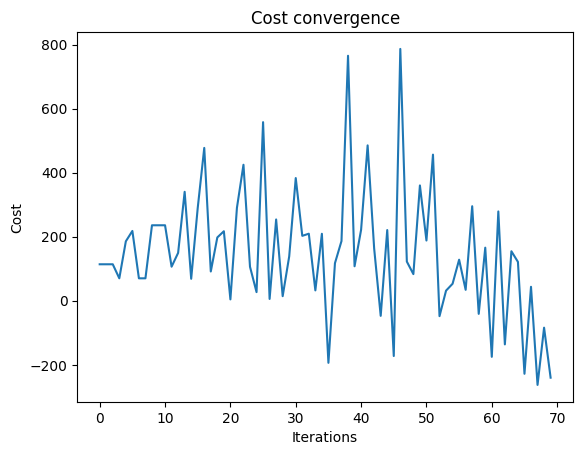

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(combi.cost_trace)
axes.set_xlabel("Iterations")
axes.set_ylabel("Cost")
axes.set_title("Cost convergence")

## Presenting the Quantum Results

In order to get samples with the optimized parameters, we call the `sample` method. Since this is a quantum solution with probablistic results, there is a defined probability for each result (shown in a histogram), where the solution is chosen as the most probable one. Translate the solution in terms of qubits, to the location in space of the amino acids, thereby creating a sketch of the protein folding for the sequence:

In [9]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
0,"{'f': [0, 0, 1, 0, 0, 1], 'interaction': [1]}",0.057129,-2600
1,"{'f': [1, 1, 1, 0, 0, 1], 'interaction': [1]}",0.054199,-2600
37,"{'f': [0, 0, 0, 0, 0, 1], 'interaction': [1]}",0.008789,-900
24,"{'f': [0, 1, 1, 0, 1, 1], 'interaction': [1]}",0.010254,-900
7,"{'f': [0, 1, 1, 0, 0, 1], 'interaction': [1]}",0.026367,-900


We will also want to compare the optimized results to uniformly sampled results:

In [10]:
uniform_result = combi.sample_uniform()

And compare the histograms:

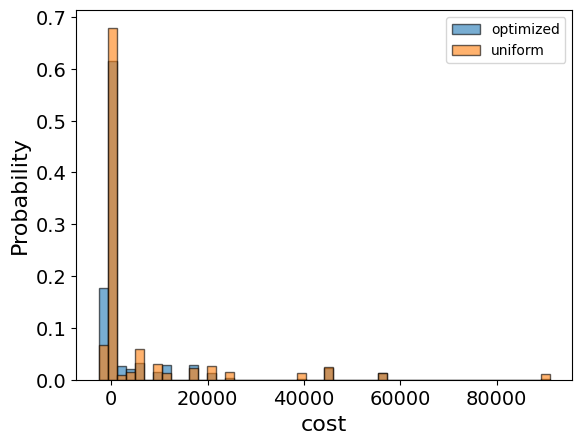

In [11]:
optimization_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the solution:

In [12]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'f': [0, 0, 1, 0, 0, 1], 'interaction': [1]}

In [ ]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]["f"]

a = np.array([1, 0, 0, 1])
N = len(my_protein)
R = np.append(a, list(best_solution[0 : 2 * (N - 3)]))

x = [0]
y = [0]
z = [0]
for i in range(N - 1):
    if (1 - R[2 * i]) * (1 - R[2 * i + 1]) == 1:
        x.append(x[i] + (-1) ** (i + 1))
        y.append(y[i] + (-1) ** (i))
        z.append(z[i] + (-1) ** (i + 1))
    if R[2 * i] * (1 - R[2 * i + 1]) == 1:
        x.append(x[i] + (-1) ** (i + 1))
        y.append(y[i] + (-1) ** (i + 1))
        z.append(z[i] + (-1) ** (i))
    if R[2 * i + 1] * (1 - R[2 * i]) == 1:
        x.append(x[i] + (-1) ** (i))
        y.append(y[i] + (-1) ** (i + 1))
        z.append(z[i] + (-1) ** (i + 1))
    if R[2 * i] * R[2 * i + 1] == 1:
        x.append(x[i] + (-1) ** (i))
        y.append(y[i] + (-1) ** (i))
        z.append(z[i] + (-1) ** (i))

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z)])
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
fig.show()

## Comparing to Classical Results
Solve the optimization model for the defined amino sequence by classical optimization, and present the results, thereby comparing to the QAOA performance. A mismatch of the classical and quantum solution indicates a need to tune the QAOA parameters:

In [14]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(protein_model)

protein_model.display()

Model protein_folding

  Variables:
    f : Size=6, Index=f_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   1.0 :     1 : False : False : Binary
    interaction : Size=1, Index=interaction_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   1.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : -2600.0

  Constraints:
    None


In [ ]:
best_classical_solution = [pyo.value(protein_model.f[i]) for i in range(2 * (N - 3))]

a = np.array([1, 0, 0, 1])
N = len(my_protein)
R_c = np.append(a, best_classical_solution)

x = [0]
y = [0]
z = [0]
for i in range(N - 1):
    if (1 - R_c[2 * i]) * (1 - R_c[2 * i + 1]) == 1:
        x.append(x[i] + (-1) ** (i + 1))
        y.append(y[i] + (-1) ** (i))
        z.append(z[i] + (-1) ** (i + 1))
    if R_c[2 * i] * (1 - R_c[2 * i + 1]) == 1:
        x.append(x[i] + (-1) ** (i + 1))
        y.append(y[i] + (-1) ** (i + 1))
        z.append(z[i] + (-1) ** (i))
    if R_c[2 * i + 1] * (1 - R_c[2 * i]) == 1:
        x.append(x[i] + (-1) ** (i))
        y.append(y[i] + (-1) ** (i + 1))
        z.append(z[i] + (-1) ** (i + 1))
    if R_c[2 * i] * R_c[2 * i + 1] == 1:
        x.append(x[i] + (-1) ** (i))
        y.append(y[i] + (-1) ** (i))
        z.append(z[i] + (-1) ** (i))

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z)])
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
fig.show()

## References
[1] [Levinthal's paradox.](https://en.wikipedia.org/wiki/Levinthal%27s_paradox)

[2] [Robert, Anton, Panagiotis Kl Barkoutsos, Stefan Woerner, and Ivano Tavernelli. "Resource-efficient quantum algorithm for protein folding." npj Quantum Information 7, no. 1 (2021): 1-5.](https://www.nature.com/articles/s41534-021-00368-4)

[3] [Miyazawa, S. & Jernigan, R. L. Residue-residue potentials with a favorable contact pair term and an unfavorable high packing density term, for simulation and threading. J. Mol. Biol. 256, 623–644 (1996).](https://pubmed.ncbi.nlm.nih.gov/8604144/)

<a id='QAOA'>[4]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)